In [30]:
import os 
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import re
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize, sent_tokenize
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from tqdm import tqdm
import kagglehub
import warnings
warnings.filterwarnings('ignore')

In [9]:
# https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset
# path = kagglehub.dataset_download("jackksoncsie/spam-email-dataset")
data = pd.read_csv('emails.csv')

In [11]:
data.head(3)

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1


### PREPROCESSING

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [14]:
data.isna().sum()

text    0
spam    0
dtype: int64

In [23]:
data.text[0]

"Subject: naturally irresistible your corporate identity  lt is really hard to recollect a company : the  market is full of suqgestions and the information isoverwhelminq ; but a good  catchy logo , stylish statlonery and outstanding website  will make the task much easier .  we do not promise that havinq ordered a iogo your  company will automaticaily become a world ieader : it isguite ciear that  without good products , effective business organization and practicable aim it  will be hotat nowadays market ; but we do promise that your marketing efforts  will become much more effective . here is the list of clear  benefits : creativeness : hand - made , original logos , specially done  to reflect your distinctive company image . convenience : logo and stationery  are provided in all formats ; easy - to - use content management system letsyou  change your website content and even its structure . promptness : you  will see logo drafts within three business days . affordability : your  ma

In [16]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'subject[:\s]*', '', text)
    text = re.sub(r're\s*:', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z]', ' ', text)
    return re.sub(r'\s+', ' ', text).strip()

In [20]:
data['X'] = data['text'].apply(lambda text: preprocess_text(text))
data['len_X'] = data['X'].apply(lambda x: len(x.split(' ')))

In [21]:
data.head()

,text,spam,X,len_X
0,Subject: naturally irresistible your corporate...,1,naturally irresistible your corporate identity...,187
1,Subject: the stock trading gunslinger fanny i...,1,the stock trading gunslinger fanny is merrill ...,88
2,Subject: unbelievable new homes made easy im ...,1,unbelievable new homes made easy im wanting to...,74
3,Subject: 4 color printing special request add...,1,color printing special request additional info...,64
4,"Subject: do not have money , get software cds ...",1,do not have money get software cds from here s...,39


### EDA

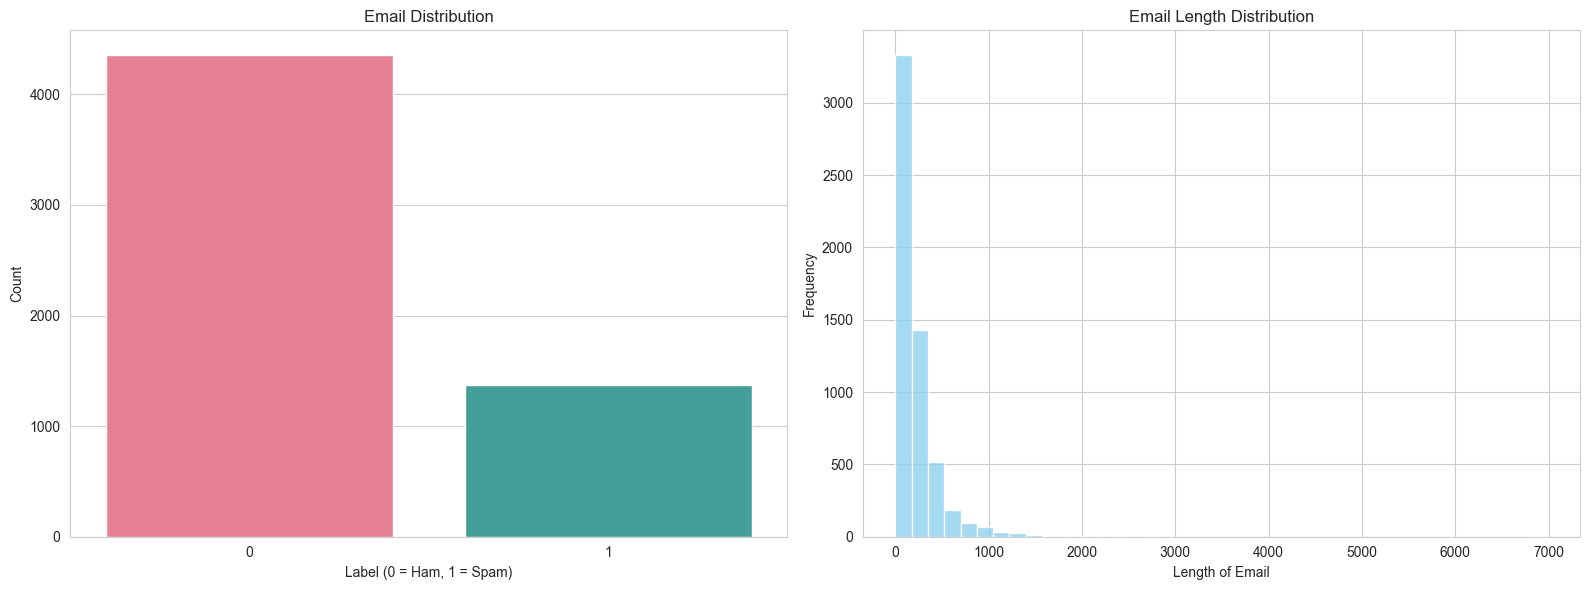

In [32]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=data, x='spam', palette='husl', ax=axes[0])
axes[0].set_title("Email Distribution", fontsize=12)
axes[0].set_xlabel("Label (0 = Ham, 1 = Spam)", fontsize=10)
axes[0].set_ylabel("Count", fontsize=10)

sns.histplot(data=data, x='len_X', bins=40, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title("Email Length Distribution", fontsize=12)
axes[1].set_xlabel("Length of Email", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

plt.tight_layout()
plt.show()

In [36]:
data_cropped = data[data['len_X'] < 750].reset_index(drop=True)

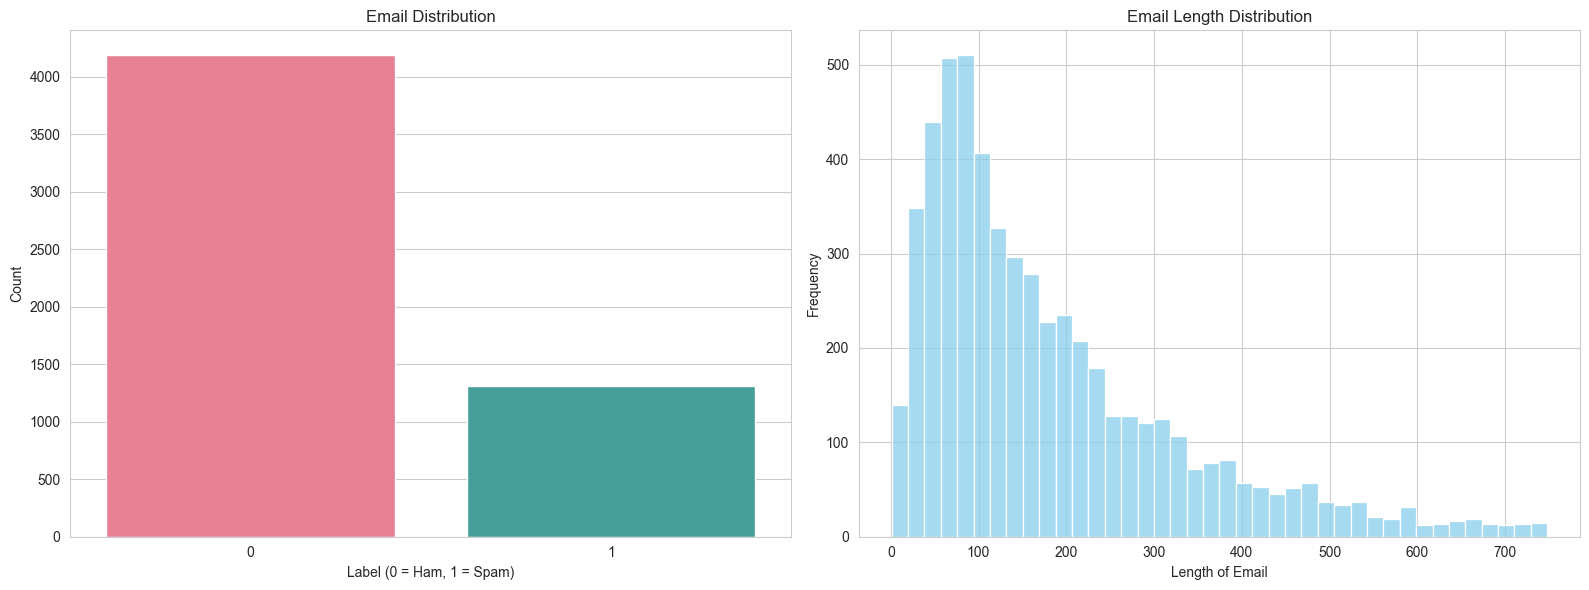

In [35]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.countplot(data=data_cropped, x='spam', palette='husl', ax=axes[0])
axes[0].set_title("Email Distribution", fontsize=12)
axes[0].set_xlabel("Label (0 = Ham, 1 = Spam)", fontsize=10)
axes[0].set_ylabel("Count", fontsize=10)

sns.histplot(data=data_cropped, x='len_X', bins=40, kde=False, ax=axes[1], color='skyblue')
axes[1].set_title("Email Length Distribution", fontsize=12)
axes[1].set_xlabel("Length of Email", fontsize=10)
axes[1].set_ylabel("Frequency", fontsize=10)

plt.tight_layout()
plt.show()

### TRAINING

In [132]:
X_train, X_test, y_train, y_test = train_test_split(
    data_cropped['X'],
    data_cropped['spam'],
    train_size=0.8,
    random_state=42,
    stratify=data_cropped['spam']
)

X_train = X_train.tolist()
y_train = y_train.tolist()
X_test = X_test.tolist()
y_test = y_test.tolist()

In [133]:
class Vocab:
    def __init__(self, data):
        tokens = set()
        self.max_seq_len = 0
        for review in data:
            words = review.split()
            self.max_seq_len = max(self.max_seq_len, len(words) + 2)
            tokens.update(words)

        self.token_to_idx = {token: idx + 1 for idx, token in enumerate(sorted(tokens))}
        self.token_to_idx['<PAD>'] = 0
        self.token_to_idx['<UNK>'] = len(self.token_to_idx)

        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
        self.vocab_len = len(self.token_to_idx)


class SpamDataset(Dataset):
    def __init__(self, X, y, vocab):
        self.X, self.y, self.vocab = X, y, vocab

    def vectorize(self, text):
        ids = [self.vocab.token_to_idx.get(w, self.vocab.token_to_idx['<UNK>']) for w in text.split()]
        ids = ids[:self.vocab.max_seq_len] + [self.vocab.token_to_idx['<PAD>']] * (self.vocab.max_seq_len - len(ids))
        return torch.tensor(ids)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.vectorize(self.X[idx]), self.y[idx]

def compute_metrics(model, loader):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in loader:
            logits = model(x)
            probs = logits.softmax(dim=1)
            pred = logits.argmax(1)
            y_true += y.tolist()
            y_pred += pred.tolist()
            y_prob += probs[:, 1].tolist()
    acc = sum([a == b for a, b in zip(y_true, y_pred)]) / len(y_true)
    return acc, f1_score(y_true, y_pred), roc_auc_score(y_true, y_prob)

def train_model(model, train_loader, val_loader, epochs=5, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    history = {
        'Epoch': [],
        'Train Loss': [],
        'Train Accuracy': [],
        'Val Accuracy': [],
        'F1 Score': [],
        'ROC AUC': []
    }
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0
        
        for x, y in train_loader:
            optimizer.zero_grad()
            logits = model(x)
            loss = loss_fn(logits, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            preds = logits.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)
        
        train_acc = correct / total
        val_acc, f1, roc = compute_metrics(model, val_loader)
        
        history['Epoch'].append(epoch + 1)
        history['Train Loss'].append(total_loss)
        history['Train Accuracy'].append(train_acc)
        history['Val Accuracy'].append(val_acc)
        history['F1 Score'].append(f1)
        history['ROC AUC'].append(roc)
        
        print(
            f"Epoch {epoch+1} | Loss: {total_loss:.4f} | "
            f"Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | "
            f"F1: {f1:.4f} | ROC AUC: {roc:.4f}"
        )
    
    df_history = pd.DataFrame(history)
    return df_history


def plot_training_stats(results, model_name, title="Training Statistics over Epochs"):
    sns.set_style("whitegrid")
    fig, ax1 = plt.subplots(figsize=(10, 4))

    epochs = results['Epoch']
    sns.lineplot(x=epochs, y=results['Train Loss'], marker='o', color='salmon', ax=ax1, label='Train Loss')
    ax1.set_ylabel("Cross-Entropy Loss", fontsize=12)
    ax1.tick_params(axis='y')
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_title(model_name + ': ' + title, fontsize=14)

    ax2 = ax1.twinx()
    sns.lineplot(x=epochs, y=results['Train Accuracy'], marker='x', color='lightpink', ax=ax2, label='Train Accuracy')
    sns.lineplot(x=epochs, y=results['Val Accuracy'], marker='x', color='olivedrab', ax=ax2, label='Val Accuracy')
    sns.lineplot(x=epochs, y=results['F1 Score'], marker='.', color='sandybrown', ax=ax2, label='F1 Score')
    sns.lineplot(x=epochs, y=results['ROC AUC'], marker='*', color='lightsteelblue', ax=ax2, label='ROC AUC')
    ax2.set_ylabel("Metrics (0–1)", fontsize=12)
    ax2.tick_params(axis='y')

    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines2, labels2, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

In [134]:
vocabulary = Vocab(X_train)

train_reviews = SpamDataset(X_train, y_train, vocabulary)
test_reviews = SpamDataset(X_test, y_test, vocabulary)

train_loader = DataLoader(train_reviews, batch_size=64)
test_loader = DataLoader(test_reviews, batch_size=64)

#### Linear Neural Network with Embeddings

In [135]:
class LinearModel(nn.Module):
    def __init__(self, vocab, emb_size=64, embedding_matrix=None, freeze_embeddings=True):
        super().__init__()
        self.vocab_size = vocab.vocab_len
        self.seq_len = vocab.max_seq_len
        self.embedding = nn.Embedding(self.vocab_size, emb_size)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = not freeze_embeddings

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.seq_len * emb_size, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = self.classifier(x)
        return x

In [136]:
linear_model = LinearModel(vocabulary, 64)

In [137]:
%%time
results = train_model(model=linear_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)

Epoch 1 | Loss: 54.8344 | Train Acc: 0.7482 | Val Acc: 0.8073 | F1: 0.3161 | ROC AUC: 0.8623
Epoch 2 | Loss: 20.5487 | Train Acc: 0.8682 | Val Acc: 0.8164 | F1: 0.3688 | ROC AUC: 0.9235
Epoch 3 | Loss: 8.3095 | Train Acc: 0.9552 | Val Acc: 0.8464 | F1: 0.5212 | ROC AUC: 0.9567
Epoch 4 | Loss: 9.7819 | Train Acc: 0.9425 | Val Acc: 0.9118 | F1: 0.7887 | ROC AUC: 0.9630
Epoch 5 | Loss: 7.1054 | Train Acc: 0.9625 | Val Acc: 0.9073 | F1: 0.7713 | ROC AUC: 0.9721
CPU times: user 23 s, sys: 46.6 s, total: 1min 9s
Wall time: 7.94 s


In [138]:
results

,Epoch,Train Loss,Train Accuracy,Val Accuracy,F1 Score,ROC AUC
0,1,54.834362,0.748182,0.807273,0.316129,0.862252
1,2,20.548743,0.868182,0.816364,0.368750,0.923536
2,3,8.309486,0.955227,0.846364,0.521246,0.956745
3,4,9.781858,0.942500,0.911818,0.788671,0.963010
4,5,7.105430,0.962500,0.907273,0.771300,0.972102


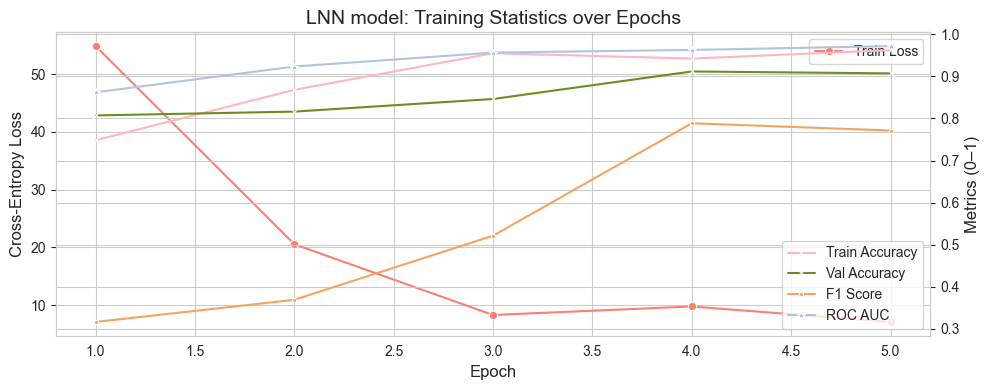

In [139]:
plot_training_stats(results, 'LNN model')

#### Convolutional Neural Network with Embeddings

In [144]:
class ModelConv(nn.Module):
    def __init__(self, vocab, emb_size, embedding_matrix=None, freeze_embeddings=True):
        super().__init__()
        self.emb_size = emb_size
        self.max_seq_len = vocab.max_seq_len
        self.vocab_len = vocab.vocab_len

        self.embedding = nn.Embedding(self.vocab_len, self.emb_size)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = not freeze_embeddings

        self.layer1 = nn.Sequential(
            nn.Conv1d(self.emb_size, 32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(
            nn.Linear(128 * (self.max_seq_len // 8), 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [145]:
cnn_model = ModelConv(vocabulary, 64)

In [146]:
%%time
results = train_model(model=cnn_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)

Epoch 1 | Loss: 26.8961 | Train Acc: 0.8264 | Val Acc: 0.9091 | F1: 0.7817 | ROC AUC: 0.9660
Epoch 2 | Loss: 8.3273 | Train Acc: 0.9500 | Val Acc: 0.9309 | F1: 0.8376 | ROC AUC: 0.9829
Epoch 3 | Loss: 3.0860 | Train Acc: 0.9830 | Val Acc: 0.9282 | F1: 0.8271 | ROC AUC: 0.9899
Epoch 4 | Loss: 1.1539 | Train Acc: 0.9948 | Val Acc: 0.9545 | F1: 0.9000 | ROC AUC: 0.9918
Epoch 5 | Loss: 0.2408 | Train Acc: 0.9993 | Val Acc: 0.9600 | F1: 0.9182 | ROC AUC: 0.9899
CPU times: user 5min 47s, sys: 12min 16s, total: 18min 4s
Wall time: 1min 57s


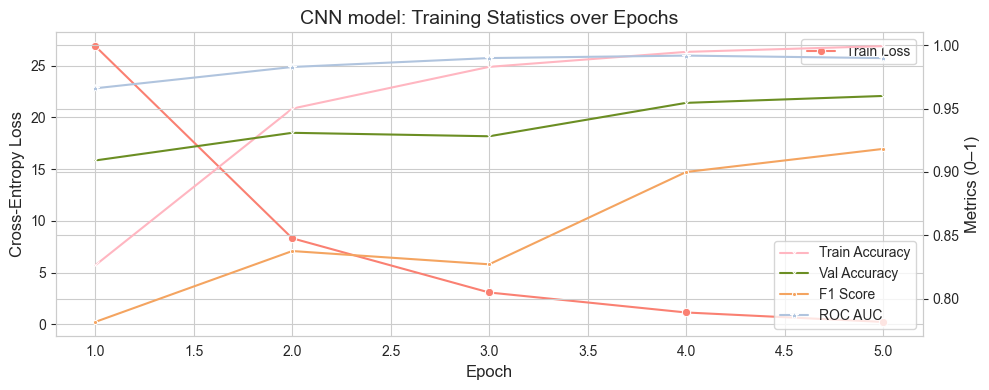

In [149]:
plot_training_stats(results, 'CNN model')

#### Recurrent Neural Network with Embeddings

In [150]:
class ModelRNN(nn.Module):
    def __init__(self, vocab, emb_size, rnn_type='GRU', embedding_matrix=None, freeze_embeddings=True):
        super().__init__()
        self.emb_size = emb_size
        self.vocab_len = vocab.vocab_len
        self.max_seq_len = vocab.max_seq_len

        self.embedding = nn.Embedding(self.vocab_len, self.emb_size)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(embedding_matrix)
            self.embedding.weight.requires_grad = not freeze_embeddings

        if rnn_type == 'GRU':
            self.rnn = nn.GRU(self.emb_size, 256, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(self.emb_size, 256, batch_first=True)
        elif rnn_type == 'RNN':
            self.rnn = nn.RNN(self.emb_size, 256, batch_first=True)
        else:
            raise ValueError("rnn_type must be 'GRU', 'LSTM', or 'RNN'")

        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        x = self.embedding(x)
        output, _ = self.rnn(x)
        x = output[:, -1, :]
        x = self.fc(x)
        return x


In [151]:
rnn_model = ModelRNN(vocabulary, 64)

In [152]:
%%time
results = train_model(model=cnn_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)

Epoch 1 | Loss: 2.2663 | Train Acc: 0.9914 | Val Acc: 0.9573 | F1: 0.9043 | ROC AUC: 0.9894
Epoch 2 | Loss: 0.6212 | Train Acc: 0.9968 | Val Acc: 0.9618 | F1: 0.9195 | ROC AUC: 0.9892
Epoch 3 | Loss: 0.2429 | Train Acc: 0.9986 | Val Acc: 0.9709 | F1: 0.9387 | ROC AUC: 0.9923
Epoch 4 | Loss: 0.0301 | Train Acc: 1.0000 | Val Acc: 0.9691 | F1: 0.9351 | ROC AUC: 0.9920
Epoch 5 | Loss: 0.0067 | Train Acc: 1.0000 | Val Acc: 0.9727 | F1: 0.9430 | ROC AUC: 0.9921
CPU times: user 5min 51s, sys: 12min 18s, total: 18min 10s
Wall time: 1min 57s


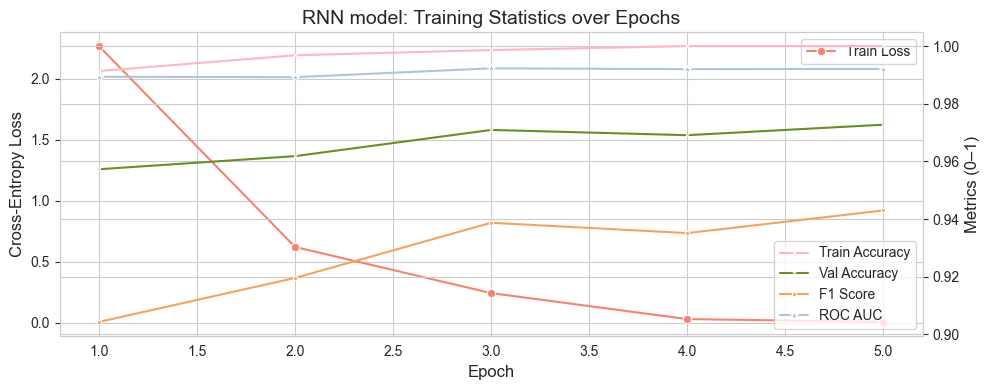

In [153]:
plot_training_stats(results, 'RNN model')

### Neural Networks with Pre-Trained Embeddings

In [140]:
def load_glove_embeddings(filepath, vocab, emb_dim):
    embeddings_index = {}
    with open(filepath, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab.vocab_len, emb_dim)).astype(np.float32)

    for word, idx in vocab.token_to_idx.items():
        vector = embeddings_index.get(word)
        if vector is not None:
            embedding_matrix[idx] = vector

    return torch.tensor(embedding_matrix)

In [141]:
embedding_matrix = load_glove_embeddings("glove.6B/glove.6B.100d.txt", vocabulary, 100)

Epoch 1 | Loss: 22.4204 | Train Acc: 0.8693 | Val Acc: 0.9173 | F1: 0.8378 | ROC AUC: 0.9525
Epoch 2 | Loss: 4.7387 | Train Acc: 0.9766 | Val Acc: 0.9091 | F1: 0.8062 | ROC AUC: 0.9489
Epoch 3 | Loss: 2.7652 | Train Acc: 0.9870 | Val Acc: 0.8991 | F1: 0.7363 | ROC AUC: 0.9637
Epoch 4 | Loss: 2.7722 | Train Acc: 0.9880 | Val Acc: 0.9473 | F1: 0.8845 | ROC AUC: 0.9818
Epoch 5 | Loss: 0.4523 | Train Acc: 0.9986 | Val Acc: 0.9327 | F1: 0.8398 | ROC AUC: 0.9768


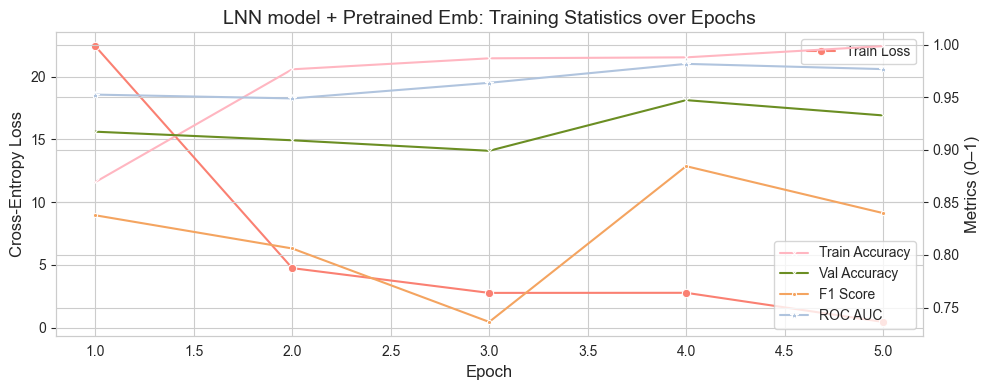

CPU times: user 28.1 s, sys: 50.8 s, total: 1min 18s
Wall time: 8.45 s


In [154]:
%%time
linear_model = LinearModel(vocabulary, emb_size=100, embedding_matrix=embedding_matrix, freeze_embeddings=True)
results = train_model(model=linear_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)
plot_training_stats(results, 'LNN model + Pretrained Emb')

Epoch 1 | Loss: 16.2550 | Train Acc: 0.9011 | Val Acc: 0.9655 | F1: 0.9261 | ROC AUC: 0.9939
Epoch 2 | Loss: 4.3151 | Train Acc: 0.9752 | Val Acc: 0.9600 | F1: 0.9203 | ROC AUC: 0.9931
Epoch 3 | Loss: 2.7890 | Train Acc: 0.9839 | Val Acc: 0.9736 | F1: 0.9462 | ROC AUC: 0.9955
Epoch 4 | Loss: 3.0514 | Train Acc: 0.9848 | Val Acc: 0.9309 | F1: 0.8296 | ROC AUC: 0.9957
Epoch 5 | Loss: 1.5639 | Train Acc: 0.9911 | Val Acc: 0.9800 | F1: 0.9579 | ROC AUC: 0.9958


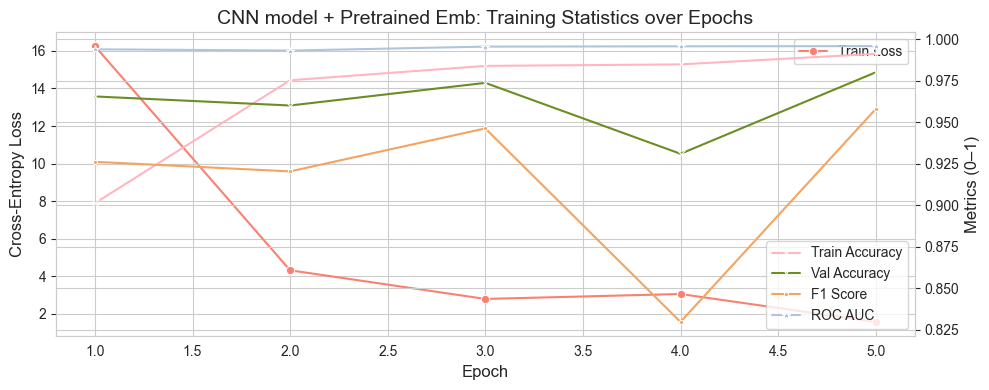

CPU times: user 6min 38s, sys: 13min 15s, total: 19min 54s
Wall time: 2min 9s


In [155]:
%%time
cnn_model = ModelConv(vocabulary, emb_size=100, embedding_matrix=embedding_matrix, freeze_embeddings=True)
results = train_model(model=cnn_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)
plot_training_stats(results, 'CNN model + Pretrained Emb')

Epoch 1 | Loss: 39.2039 | Train Acc: 0.7555 | Val Acc: 0.7627 | F1: 0.0000 | ROC AUC: 0.5899
Epoch 2 | Loss: 35.6695 | Train Acc: 0.7623 | Val Acc: 0.7627 | F1: 0.0000 | ROC AUC: 0.6312
Epoch 3 | Loss: 22.1758 | Train Acc: 0.8680 | Val Acc: 0.7782 | F1: 0.1701 | ROC AUC: 0.9044
Epoch 4 | Loss: 16.8231 | Train Acc: 0.9098 | Val Acc: 0.9182 | F1: 0.8214 | ROC AUC: 0.9636
Epoch 5 | Loss: 13.1243 | Train Acc: 0.9311 | Val Acc: 0.9273 | F1: 0.8354 | ROC AUC: 0.9731


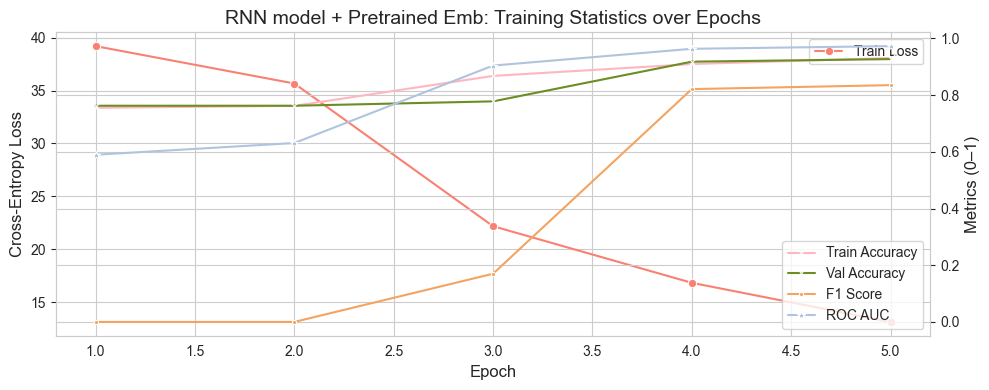

CPU times: user 7min 26s, sys: 20min 42s, total: 28min 8s
Wall time: 3min 4s


In [156]:
%%time
rnn_model = ModelRNN(vocabulary, emb_size=100, embedding_matrix=embedding_matrix, freeze_embeddings=True)
results = train_model(model=rnn_model, train_loader=train_loader, val_loader=test_loader, epochs=5, lr=0.001)
plot_training_stats(results, 'RNN model + Pretrained Emb')

### RESULT

The Linear model with randomly initialized embeddings achieved a validation accuracy of 91%, with an F1 score of 0.77 and a ROC AUC of 0.97 after 5 epochs. Incorporating pretrained embeddings improved the metrics slightly, reaching 93% validation accuracy, F1 = 0.84, and ROC AUC = 0.98.


The CNN performed better than the Linear model, demonstrating its ability to capture local dependencies in text. Without pretrained embeddings, the CNN achieved 96% validation accuracy, F1 = 0.91, and ROC AUC = 0.99. Using pretrained embeddings further improved the results slightly, yielding an F1 score above 0.95 and a ROC AUC close to 0.995.


The RNN with GRU units achieved the best performance among the tested models. With randomly initialized embeddings, the RNN reached 97% validation accuracy, F1 = 0.94, and ROC AUC = 0.99. When initialized with pretrained embeddings, the RNN achieved a validation accuracy of 98%, an F1 score of 0.96, and a ROC AUC of nearly 0.97.